## Libraries

In [100]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

## Load dataset

In [101]:
ds = load_dataset("dair-ai/emotion", "split")

# Task 1: Data Preparation

## Data set size

In [102]:
# Print number of examples
print(f"Number of train examples: {len(ds['train'])}")
print(f"Number of validation examples: {len(ds['validation'])}")
print(f"Number of test examples: {len(ds['test'])}")

Number of train examples: 16000
Number of validation examples: 2000
Number of test examples: 2000


## Step 1: Label distribution

0: sadness
1: joy
2: love
3: anger
4: fear
5: surprise


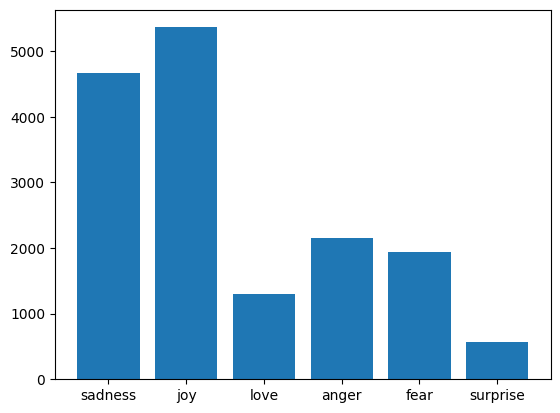

In [103]:
# Print labels and their corresponding index
for i, label in enumerate(ds["train"].features["label"].names):
    print(f"{i}: {label}")

# Plot the distribution of the labels
plt.hist(ds["train"]["label"], bins=range(7), align='left', rwidth=0.8)

# Center the x-axis ticks on the histogram bars
plt.xticks([i for i in range(6)], ds["train"].features["label"].names)

# Display the plot
plt.show()

## Step 2: Extract texts for all splits and split each text into tokens

In [104]:
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+|[!?'´`]+")
example_sentence = "This?.is,a:custom;tokenization example!<"
example_tokens = tokenizer.tokenize(example_sentence)
print(example_tokens)

['This', '?', 'is', 'a', 'custom', 'tokenization', 'example', '!']


In [105]:
train_tokens = [tokenizer.tokenize(example["text"]) for example in ds["train"]]
print(ds["train"][0]["text"])
print(train_tokens[0])

print("")
val_tokens = [tokenizer.tokenize(example["text"]) for example in ds["validation"]]
print(ds["validation"][0]["text"])
print(val_tokens[0])

print("")
test_tokens = [tokenizer.tokenize(example["text"]) for example in ds["test"]]
print(ds["test"][0]["text"])
print(test_tokens[0])

i didnt feel humiliated
['i', 'didnt', 'feel', 'humiliated']

im feeling quite sad and sorry for myself but ill snap out of it soon
['im', 'feeling', 'quite', 'sad', 'and', 'sorry', 'for', 'myself', 'but', 'ill', 'snap', 'out', 'of', 'it', 'soon']

im feeling rather rotten so im not very ambitious right now
['im', 'feeling', 'rather', 'rotten', 'so', 'im', 'not', 'very', 'ambitious', 'right', 'now']


Train:
Length range: 2-66
Mean length: 19.1663125
Standard deviation: 120.70452765234376

Validation:
Length range: 2-61
Mean length: 18.866
Standard deviation: 116.86304399999999

Test:
Length range: 3-61
Mean length: 19.154
Standard deviation: 121.211284


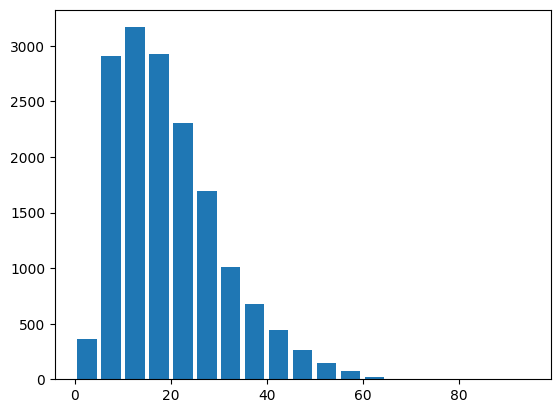

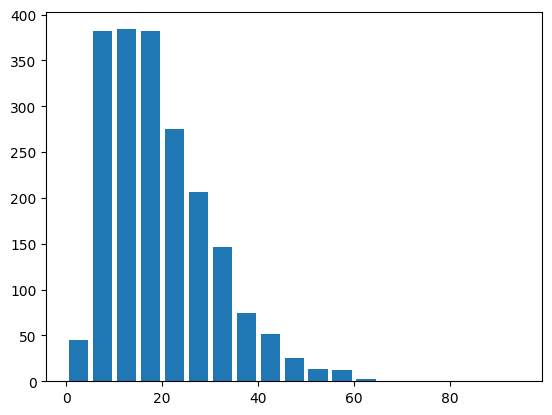

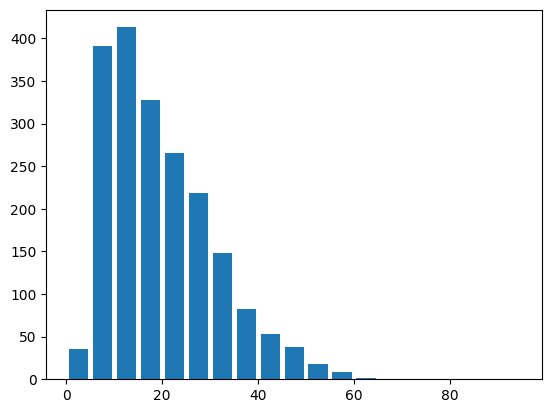

In [106]:
# Distribution of text lengths by providing its range, mean, and standard deviation
train_lengths = [len(tokens) for tokens in train_tokens]
val_lengths = [len(tokens) for tokens in val_tokens]
test_lengths = [len(tokens) for tokens in test_tokens]

print("Train:")
print(f"Length range: {min(train_lengths)}-{max(train_lengths)}")
print(f"Mean length: {sum(train_lengths) / len(train_lengths)}")
print(f"Standard deviation: {sum([(length - sum(train_lengths) / len(train_lengths)) ** 2 for length in train_lengths]) / len(train_lengths)}")

print("\nValidation:")
print(f"Length range: {min(val_lengths)}-{max(val_lengths)}")
print(f"Mean length: {sum(val_lengths) / len(val_lengths)}")
print(f"Standard deviation: {sum([(length - sum(val_lengths) / len(val_lengths)) ** 2 for length in val_lengths]) / len(val_lengths)}")

print("\nTest:")
print(f"Length range: {min(test_lengths)}-{max(test_lengths)}")
print(f"Mean length: {sum(test_lengths) / len(test_lengths)}")
print(f"Standard deviation: {sum([(length - sum(test_lengths) / len(test_lengths)) ** 2 for length in test_lengths]) / len(test_lengths)}")

# Plot the distribution of the text lengths
plt.hist(train_lengths, bins=range(0, 100, 5), rwidth=0.8)
plt.show()

plt.hist(val_lengths, bins=range(0, 100, 5), rwidth=0.8)
plt.show()

plt.hist(test_lengths, bins=range(0, 100, 5), rwidth=0.8)
plt.show()

## Step 3: Build a vocabulary

In [107]:
vocabulary = {"<PAD>": 0}
for tokens in train_tokens:
    for token in tokens:
        if token not in vocabulary:
            vocabulary[token] = len(vocabulary)

print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 15213


## Step 4: Encode all texts with the vocabulary

In [108]:
def encode_text(tokens):
    return [vocabulary[token] if token in vocabulary else 1 for token in tokens]

train_encoded = [encode_text(tokens) for tokens in train_tokens]
val_encoded = [encode_text(tokens) for tokens in val_tokens]
test_encoded = [encode_text(tokens) for tokens in test_tokens]

## Step 5: Maximum sequence length

In [109]:
max_length = 20
def pad_sequence(sequence):
    return sequence[:max_length] + [0] * (max_length - len(sequence))

train_padded = [pad_sequence(sequence) for sequence in train_encoded]
val_padded = [pad_sequence(sequence) for sequence in val_encoded]
test_padded = [pad_sequence(sequence) for sequence in test_encoded]